# Real-Time Credit Card Fraud Detection

## Basic Imports and Settings

In [1]:
# import modules from pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import seaborn as sns

# uncomment the following line if running pyspark from the notebook itself
# spark = SparkSession.builder.enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
sqlContext = SQLContext(spark)

/usr/local/Cellar/apache-spark/3.5.0/libexec/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Loading the Dataset File and Performing Basic Data Type Conversions

Source of the dataset: https://www.kaggle.com/datasets/kartik2112/fraud-detection

In [2]:
# define a reusable schema for the dataset (will be useful for the real-time portion)
ccschema = StructType([
    StructField("_c0", IntegerType(), True),
    StructField("trans_date_trans_time", TimestampType(), True),
    StructField("cc_num", StringType(), True),
    StructField("merchant", StringType(), True),
    StructField("category", StringType(), True),
    StructField("amt", DoubleType(), True),
    StructField("first", StringType(), True),
    StructField("last", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("long", DoubleType(), True),
    StructField("city_pop", DoubleType(), True),
    StructField("job", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("trans_num", StringType(), True),
    StructField("unix_time", StringType(), True),
    StructField("merch_lat", DoubleType(), True),
    StructField("merch_long", DoubleType(), True),
    StructField("is_fraud", IntegerType(), True),
])

In [3]:
# Read The data from local folder

cc = (spark.read.csv("fraudTrain.csv", schema=ccschema, header=True))
cc_test = (spark.read.csv("fraudTest.csv", schema=ccschema, header=True))

In [0]:
# Read The data in the context of Databricks

# cc = (spark.read.csv("s3://group9-ml-project/fraudTrain.csv", schema=ccschema, header=True))
# cc_test = (spark.read.csv("s3://group9-ml-project/fraudTest.csv", schema=ccschema, header=True))

In [0]:
# use this code to create some sample data from the main dataset for the purpose
# of loading transactions for the real time portion

# cc.limit(10).write.option("header",True).csv("sample")

## Exploratory Data Analysis

### A Look at the Data and its Basic Statistics

In [0]:
# let's look a the first 5 rows
pd.DataFrame(cc.take(5), columns=cc.columns)

,_c0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [0]:
# basic statistics
cc.describe().toPandas()

,summary,_c0,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,count,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675
1,mean,648337.0,4.1719204207968429E17,None,None,70.35103545606984,None,None,None,None,None,None,48800.67109722945,38.537621614905156,-90.22633537865396,88824.44056297839,None,Infinity,1.3492436367261226E9,38.53733804469928,-90.22646479897182,0.005788651743883394
2,stddev,374317.9744882685,1.3088064470002368E18,None,None,160.3160385715275,None,None,None,None,None,None,26893.222476485895,5.075808438803925,13.759076946486335,301956.36068875075,None,NaN,1.2841278423356462E7,5.109788369679179,13.771090564792416,0.07586268973125157
3,min,0,180011453250192,fraud_Abbott-Rogahn,entertainment,1.0,Aaron,Abbott,F,000 Jennifer Mills,Achille,AK,10018,20.0271,-165.6723,23.0,Academic librarian,00000ecad06b03d3a8d34b4e30b5ce3b,1325376018,19.027785,-166.671242,0
4,max,1296674,676372984911,fraud_Zulauf LLC,travel,28948.9,Zachary,Zuniga,M,99736 Rose Shoals Apt. 504,Zavalla,WY,99783,66.6933,-67.9503,2906700.0,Writer,ffffef9d89e7d02d86efb1d2ba4de008,1371816817,67.510267,-66.950902,1


In [0]:
# looking to see if there are null values
cc.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in cc.columns)).toPandas()

,_c0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Visualizing the Data Distribution

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

combine = cc.union(cc_test)
display(combine.describe())

summary,_c0,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud
count,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394
mean,537193.4400003455,4.1738603839368506E17,null,null,70.0635674753856,null,null,null,null,null,null,48813.25819075207,38.53931097925599,-90.22783229070944,88643.67450931066,null,Infinity,1.3586742188343642E9,38.538975967059045,-90.2279395091373,0.005210014716091717
stddev,366910.96048312774,1.3091152653187328E18,null,null,159.25397477398326,null,null,null,null,null,null,26881.845965862867,5.071470391380578,13.747894882569106,301487.6183436499,null,NaN,1.8195081387554534E7,5.105603877592809,13.759692112582874,0.0719921749961915
min,0,180011453250192,fraud_Abbott-Rogahn,entertainment,1.0,Aaron,Abbott,F,000 Jennifer Mills,Achille,AK,10018,20.0271,-165.6723,23.0,Academic librarian,00000ecad06b03d3a8d34b4e30b5ce3b,1325376018,19.027422,-166.671575,0
max,1296674,676372984911,fraud_Zulauf LLC,travel,28948.9,Zachary,Zuniga,M,99736 Rose Shoals Apt. 504,Zavalla,WY,99921,66.6933,-67.9503,2906700.0,Writer,ffffef9d89e7d02d86efb1d2ba4de008,1388534374,67.510267,-66.950902,1


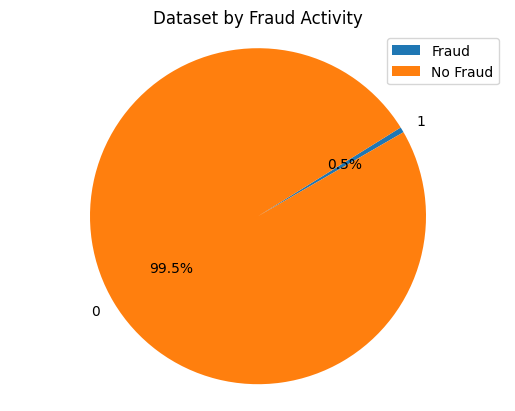

In [0]:
count_fraud = combine.select('is_fraud').groupby('is_fraud').count().toPandas()

plt.pie(count_fraud['count'], labels=count_fraud['is_fraud'], autopct='%1.1f%%', startangle=30)
plt.axis('equal')
plt.title('Dataset by Fraud Activity')
plt.legend(labels=['Fraud', 'No Fraud'])

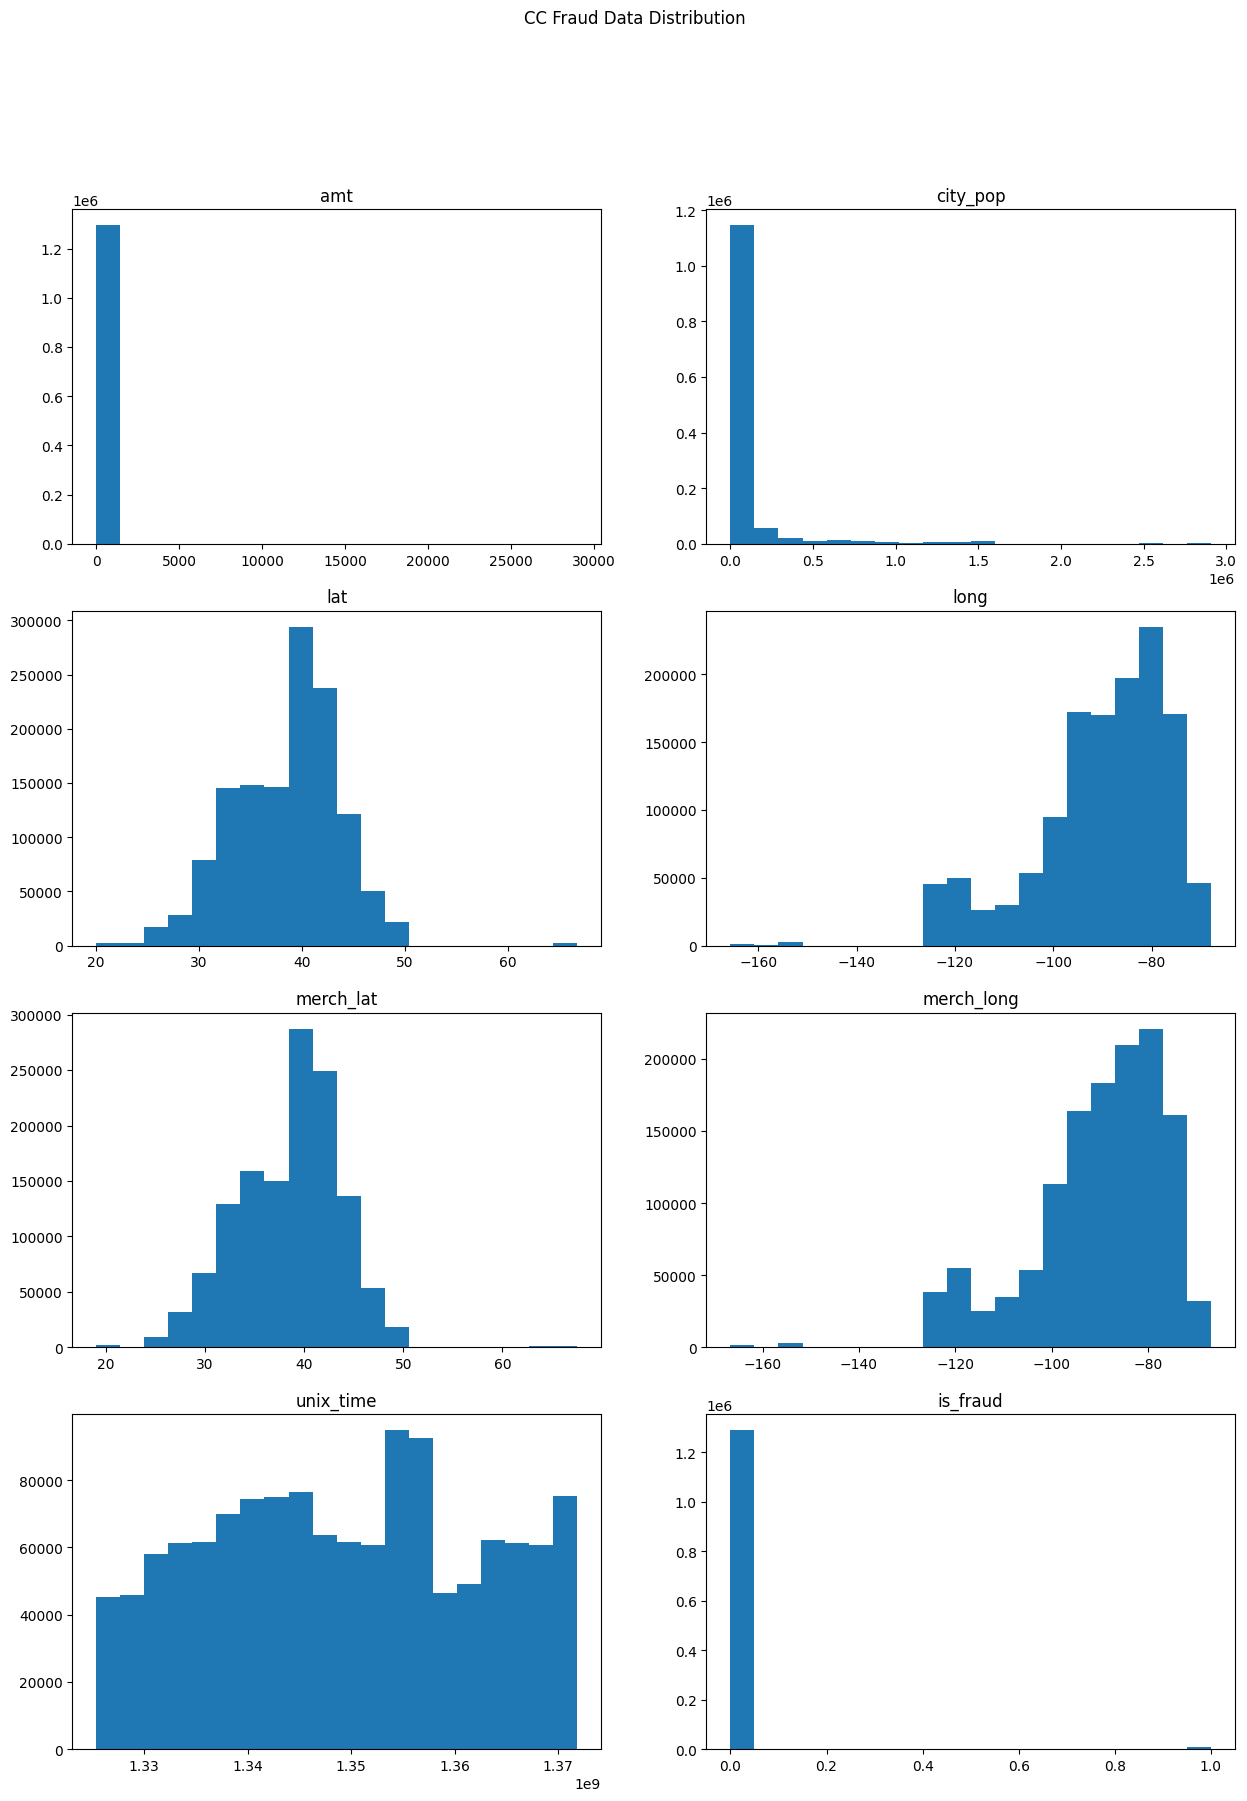

In [0]:
fig, axs = plt.subplots(4 , 2, figsize=(15, 20))
fig.suptitle('CC Fraud Data Distribution')

for idx, column in enumerate(['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'unix_time', 'is_fraud']):
    # Show histogram of the column
    bins, counts = cc.select(column).rdd.flatMap(lambda x: x).map(float).histogram(20)
    axs[idx//2][idx%2].set_title(column)
    axs[idx//2][idx%2].hist(bins[:-1], bins=bins, weights=counts)
    
plt.show()

In [0]:
cc.select("category").groupby("category").count().toPandas()

,category,count
0,travel,40507
1,misc_net,63287
2,grocery_pos,123638
3,kids_pets,113035
4,shopping_net,97543
5,grocery_net,45452
6,food_dining,91461
7,gas_transport,131659
8,personal_care,90758
9,health_fitness,85879


In [0]:
cc.select("gender").groupby("gender").count().toPandas()

,gender,count
0,F,709863
1,M,586812


### EDA -Fraud as a Function of Hour of Day

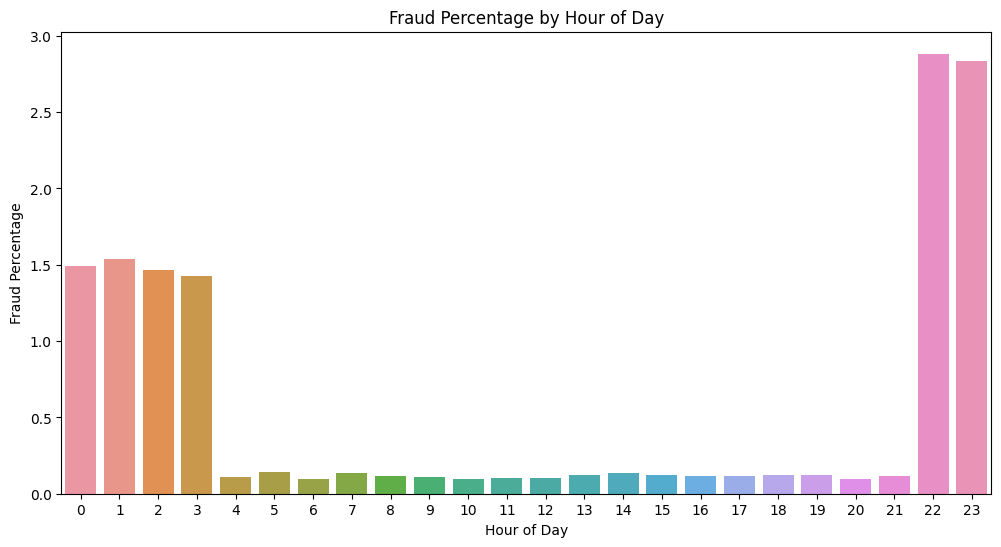

In [0]:
from pyspark.sql.functions import col, hour
from pyspark.sql import SparkSession

# Extract hour of day from timestamp
cc_prepped = cc.withColumn('hour_of_day', hour('trans_date_trans_time'))

# Group by hour_of_day and count fraud occurrences
fraud_count_per_hour = cc_prepped.groupBy('hour_of_day').agg(
    sum('is_fraud').alias('fraud_count'),
    count('is_fraud').alias('total_transactions')
)

# Calculate the percentage of fraud transactions per hour
fraud_count_per_hour = fraud_count_per_hour.withColumn(
    'fraud_percentage',
    (col('fraud_count') / col('total_transactions')) * 100
)

# Collect the data for plotting (convert to Pandas DataFrame)
fraud_count_per_hour_pandas = fraud_count_per_hour.toPandas()

# Plotting using Pandas and Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='hour_of_day', y='fraud_percentage', data=fraud_count_per_hour_pandas)
plt.title('Fraud Percentage by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Percentage')
plt.show()

### EDA-Fraud per category

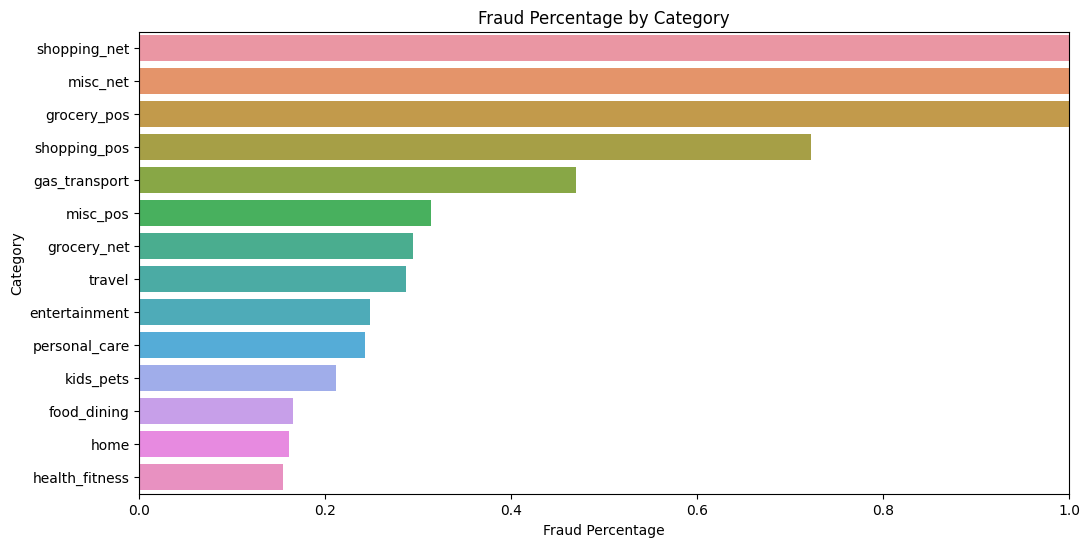

In [0]:
from pyspark.sql.functions import col, sum, count
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import when

# Group by 'category' and count fraud occurrences
fraud_count_per_category = cc_prepped.groupBy('category').agg(
    sum('is_fraud').alias('fraud_count'),
    count('is_fraud').alias('total_transactions')
)
# ensure that the fraud_count does not exceed total_transactions
fraud_count_per_category = fraud_count_per_category.withColumn(
    'fraud_count',
    when(col('fraud_count') > col('total_transactions'), col('total_transactions')).otherwise(col('fraud_count'))
)

# Calculate the percentage of fraud transactions per category, ensuring it does not exceed 100%
fraud_count_per_category = fraud_count_per_category.withColumn(
    'fraud_percentage',
    (col('fraud_count') / col('total_transactions')) * 100
)

# collect for plotting
fraud_count_per_category_pandas = fraud_count_per_category.toPandas()

# Sort the DataFrame in descending order of fraud percentage
fraud_count_per_category_pandas.sort_values(by='fraud_percentage', ascending=False, inplace=True)

# Now let's plot and set the xlim to not exceed 100%
plt.figure(figsize=(12, 6))
sns.barplot(x='fraud_percentage', y='category', data=fraud_count_per_category_pandas, orient='h')
plt.title('Fraud Percentage by Category')
plt.xlabel('Fraud Percentage')
plt.ylabel('Category')

# Set x-axis limit to not exceed 100
# plt.xlim(0, 1)
plt.show()

### EDA-Fraud per vendor

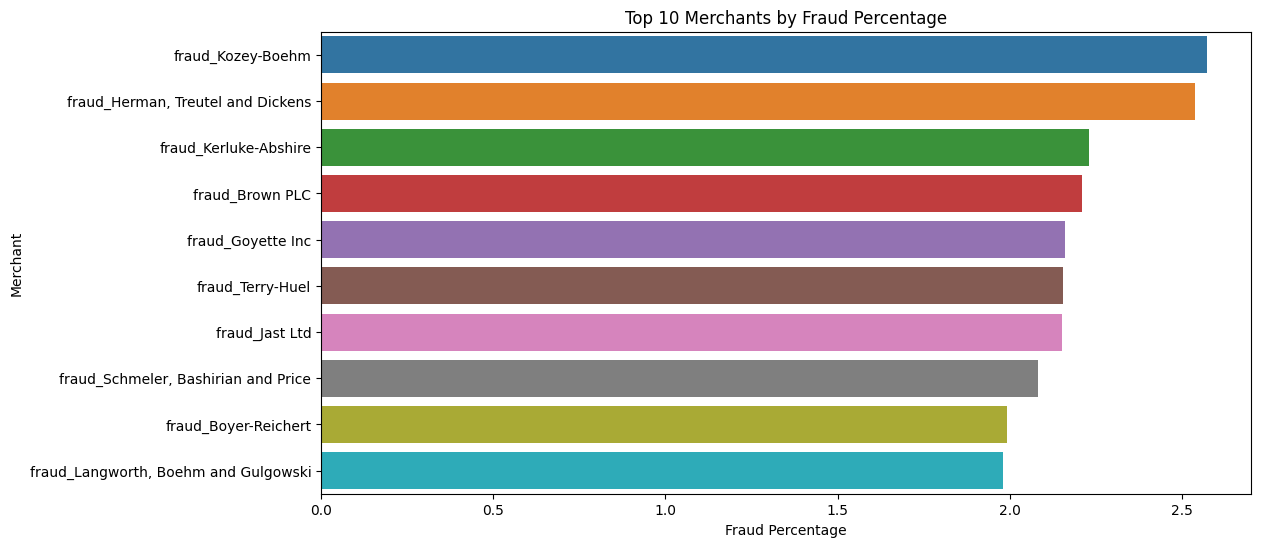

In [0]:
from pyspark.sql.functions import col, sum, count, when
from pyspark.sql import SparkSession

# Group by 'merchant' and count fraud occurrences
fraud_count_per_merchant = cc_prepped.groupBy('merchant').agg(
    sum('is_fraud').alias('fraud_count'),
    count('is_fraud').alias('total_transactions')
)

# Calculate the percentage of fraud transactions per merchant
fraud_count_per_merchant = fraud_count_per_merchant.withColumn(
    'fraud_percentage',
    (col('fraud_count') / col('total_transactions')) * 100
)

# Collect the data for analysis or plotting (convert to Pandas DataFrame if needed)
fraud_count_per_merchant_pandas = fraud_count_per_merchant.toPandas()

# If you want to visualize the top N vendors with the highest fraud percentages, you can do:
top_n = 10
fraud_count_per_merchant_pandas_top_n = fraud_count_per_merchant_pandas.nlargest(top_n, 'fraud_percentage')

# Plotting using Pandas and Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='fraud_percentage', y='merchant', data=fraud_count_per_merchant_pandas_top_n, orient='h')
plt.title('Top {} Merchants by Fraud Percentage'.format(top_n))
plt.xlabel('Fraud Percentage')
plt.ylabel('Merchant')
plt.show()

### EDA - Fraud Ratio by Age Group
Is fraud more prevalent in certain age groups than others? The analysis below suggests that seniors aged 80+ are more exposed to fraudulent transactions than other groups. This makes age group a potentially viable feature.

In [0]:
# calculate age group from date of birth. Notice the use of the floor function, which
# means that a person in the 30-40 age group would be deemed a member of the "30" group
cc_age = cc.withColumn("age_group", 
                       floor(months_between(current_date(), 
                        col("dob"))/12/10)*10)

In [0]:
# get histogram of fraudulent transactions by age group
bins, counts = (cc_age.where(col("is_fraud")==1.0)
                      .select("age_group").rdd.flatMap(lambda x: x)
                               .map(float).histogram(list(range(0,110,10))))

In [0]:
# get histogram of non-fraudulent transactions by age group
bins2, counts2 = (cc_age.where(col("is_fraud")==0.0)
                      .select("age_group").rdd.flatMap(lambda x: x)
                               .map(float).histogram(list(range(0,110,10))))

In [0]:
# calculate ratios between fraudulent and non-fraudulent transactions
def safediv(arg1, arg2):
    return arg1 / arg2 if (arg2 != 0) else 0;

ratios = list(map(safediv, counts, counts2))
# ratios

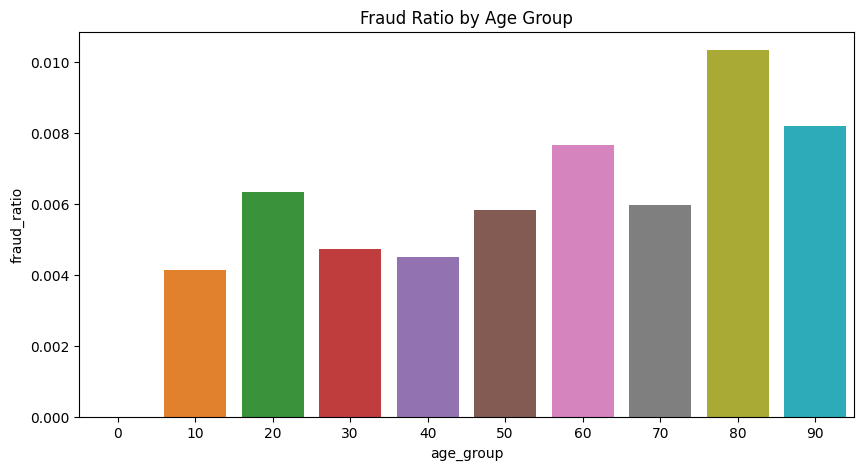

In [0]:
plt.figure(figsize = (10,5))
hist = pd.DataFrame(zip(bins,ratios), columns=['age_group','fraud_ratio'])
sns.barplot(hist, x="age_group", y="fraud_ratio").set(title='Fraud Ratio by Age Group')
plt.show()

### EDA - Fraud by Age Group and Gender

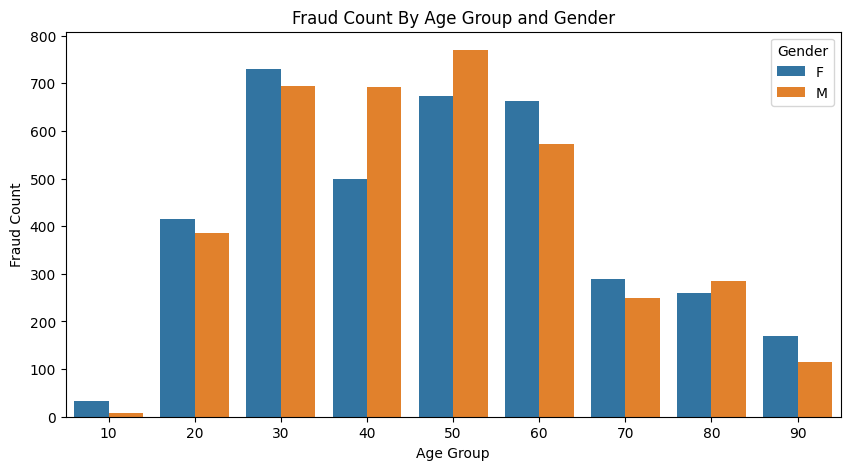

In [0]:
age_gender = cc_age.groupBy("age_group", "gender").agg({"is_fraud":"sum"}).withColumnRenamed("sum(is_fraud)","count").toPandas()
plt.figure(figsize = (10,5))
sns.barplot(x="age_group", y="count", hue="gender", data=age_gender).set(title='Fraud Count By Age Group and Gender')
plt.xlabel("Age Group")
plt.ylabel("Fraud Count")
plt.legend(title="Gender")
plt.show()

### EDA - Fraud by Amount


In [0]:
#drop any duplicates
cc = cc.dropDuplicates()
cc.describe().toPandas()

,summary,_c0,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,count,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675
1,mean,648337.0,4.1719204207968614E17,None,None,70.35103545607005,None,None,None,None,None,None,48800.67109722945,38.53762161490493,-90.22633537865288,88824.44056297839,None,Infinity,1.3492436367261226E9,38.53733804469969,-90.2264647989728,0.005788651743883394
2,stddev,374317.9744882697,1.30880644700024013E18,None,None,160.316038571528,None,None,None,None,None,None,26893.222476485873,5.075808438803942,13.759076946486278,301956.3606887512,None,NaN,1.2841278423355842E7,5.109788369679184,13.771090564792434,0.07586268973125172
3,min,0,180011453250192,fraud_Abbott-Rogahn,entertainment,1.0,Aaron,Abbott,F,000 Jennifer Mills,Achille,AK,10018,20.0271,-165.6723,23.0,Academic librarian,00000ecad06b03d3a8d34b4e30b5ce3b,1325376018,19.027785,-166.671242,0
4,max,1296674,676372984911,fraud_Zulauf LLC,travel,28948.9,Zachary,Zuniga,M,99736 Rose Shoals Apt. 504,Zavalla,WY,99783,66.6933,-67.9503,2906700.0,Writer,ffffef9d89e7d02d86efb1d2ba4de008,1371816817,67.510267,-66.950902,1


In [0]:
from pyspark.ml.feature import Bucketizer

#calculate bin edges based on every 500
bin_edge = [float(x) for x in range(0, int(cc.agg({'amt':'max'}).collect()[0]['max(amt)'])+100, 500)]

bucketizer = Bucketizer(splits=bin_edge, inputCol='amt', outputCol='bins')
cc_bin_amt = bucketizer.transform(cc)

#group by bins and fraud and count occurences 
grouped_amt = cc_bin_amt.groupby('bins', 'is_fraud').count()

#display based on highest count 
display(grouped_amt.orderBy('count', ascending=False))


bins,is_fraud,count
0.0,0,1277186
1.0,0,8996
0.0,1,3858
1.0,1,2698
2.0,0,1691
2.0,1,950
3.0,0,565
4.0,0,244
5.0,0,131
6.0,0,95


Can see that a large portion of fraud occurs for amount <= 1500

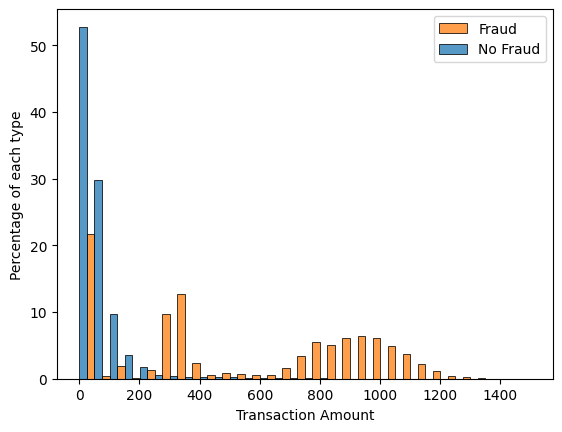

In [0]:
cc_filter = cc.filter(col('amt')<1500)
pd_cc_filter = cc_filter.toPandas()
sns.histplot(x='amt',data=pd_cc_filter,hue='is_fraud',stat='percent',multiple='dodge',common_norm=False, bins=30)
plt.xlabel('Transaction Amount')
plt.ylabel('Percentage of each type')
plt.legend(labels=['Fraud', 'No Fraud'])


Fradulent activity peaks for transactions that are under 300 and then again for transactions between 750-1250. 

### EDA Preliminary Findings

- The data appears to be clean with no missing values and duplicates
- Some of the heavily skewed features like amt and city_pop may benefit from logarithmic transformation
- The target class (is_fraud) is heavily imbalanced
- The fraud percentage is higher in the night between 23: 24pm
- Online shopping and miscellaneous internet-based transactions exhibit the highest rates of fraud
- The top five merchants with the highest fraud percentages—Kozey-Boehm, Herman LLC, Treutel-Dickens, Kerluke-Abshire, and Brown PLC
- Seniors aged 80+ are more likely to be victims of fraud than folks in other age groups.
- Gender does not affect likelihood of fradulent activity on credit card
- Fradulent activity highest for transactions under <1500

### Feature Engineering

From our EDA above, it is evident that time in the day has a strong correlation with fraud activities. A big portion of the fraudulent transactions take place between the hours of 10pm and 3am. We can make rules surrounding this finding. 

In [0]:
result = (
    cc
    .groupBy(
        expr("hour(trans_date_trans_time)").alias("hour_24"),
        "category"
    )
    .agg(
        count(expr("CASE WHEN is_fraud = 0 THEN trans_num END")).alias("non_fraud_count"),
        count(expr("CASE WHEN is_fraud = 1 THEN trans_num END")).alias("fraud_count")
    )
    .withColumn(
        "fraud_ratio",
        round(col("fraud_count") * 100.0 / (col("non_fraud_count") + col("fraud_count")), 2)
    )
    .orderBy("fraud_ratio", ascending=False)
)

result.show()

+-------+------------+---------------+-----------+-----------+
|hour_24|    category|non_fraud_count|fraud_count|fraud_ratio|
+-------+------------+---------------+-----------+-----------+
|     22| grocery_pos|            168|        134|      44.37|
|     23| grocery_pos|            193|        147|      43.24|
|     23|    misc_net|            880|        314|       26.3|
|     22|    misc_net|            909|        281|      23.61|
|     22|shopping_net|           4570|        702|      13.32|
|     23|shopping_net|           4627|        575|      11.05|
|     23|shopping_pos|           5782|        292|       4.81|
|     22|shopping_pos|           5869|        272|       4.43|
|     13| grocery_pos|            169|          7|       3.98|
|     16| grocery_pos|            181|          7|       3.72|
|     18| grocery_pos|            186|          7|       3.63|
|     15| grocery_pos|            173|          6|       3.35|
|     14| grocery_pos|            149|          5|     

The above shows the riskiest categories paired with the hours in the day. It appears that  groceries_pos, misc_net and shopping_net late night are the riskiest, generating >10% transaction fraud rate. That would be a very strong piece for our fraud detection model.

In [0]:
result = (
    cc
    .groupBy(
        expr("hour(trans_date_trans_time)").alias("hour_24"),
        round("amt", -2).alias("rounded_amount")
    )
    .agg(
        count(expr("CASE WHEN is_fraud = 0 THEN trans_num END")).alias("non_fraud_count"),
        count(expr("CASE WHEN is_fraud = 1 THEN trans_num END")).alias("fraud_count")
    )
    .withColumn(
        "fraud_ratio",
        round(col("fraud_count") * 100.0 / (col("non_fraud_count") + col("fraud_count")), 2)
    )
    .filter("fraud_ratio > 10")
    .orderBy(col("fraud_ratio").desc())  # Order by fraud_ratio in descending order
)

result.show()

+-------+--------------+---------------+-----------+-----------+
|hour_24|rounded_amount|non_fraud_count|fraud_count|fraud_ratio|
+-------+--------------+---------------+-----------+-----------+
|     22|        1000.0|             28|        324|      92.05|
|     23|        1000.0|             29|        262|      90.03|
|     23|         900.0|             40|        319|      88.86|
|     23|        1100.0|             23|        171|      88.14|
|     22|        1100.0|             26|        171|       86.8|
|     22|         900.0|             55|        352|      86.49|
|     23|         800.0|             48|        253|      84.05|
|     22|         800.0|             58|        240|      80.54|
|     22|        1200.0|             14|         45|      76.27|
|     22|         700.0|             57|        108|      65.45|
|     02|         800.0|             29|         51|      63.75|
|     23|        1200.0|             21|         36|      63.16|
|     00|         800.0| 

Pairing time with the rounded transaction amount(to the nearest hundred) also shows a very strong indicator of fraud. We can also use that in our fraud detection model.

In [0]:
result = (
    cc
    .groupBy(
        expr("hour(trans_date_trans_time)").alias("hour_24"),
        col("category"),
        round("amt", -2).alias("rounded_amount")
    )
    .agg(
        count(expr("CASE WHEN is_fraud = 0 THEN trans_num END")).alias("non_fraud_count"),
        count(expr("CASE WHEN is_fraud = 1 THEN trans_num END")).alias("fraud_count")
    )
    .withColumn(
        "fraud_ratio",
        round(col("fraud_count") * 100.0 / (col("non_fraud_count") + col("fraud_count")), 2)
    )
    .filter("fraud_ratio > 10 and fraud_count > 10")
    .orderBy(col("fraud_ratio").desc())  # Order by fraud_ratio in descending order
)

result.show()

+-------+-------------+--------------+---------------+-----------+-----------+
|hour_24|     category|rounded_amount|non_fraud_count|fraud_count|fraud_ratio|
+-------+-------------+--------------+---------------+-----------+-----------+
|     03|  grocery_pos|         400.0|              0|         42|      100.0|
|     22|  grocery_pos|         300.0|              0|        129|      100.0|
|     00|  grocery_pos|         400.0|              0|         23|      100.0|
|     23|  grocery_pos|         300.0|              0|        142|      100.0|
|     02|  grocery_pos|         400.0|              0|         36|      100.0|
|     01|  grocery_pos|         400.0|              0|         30|      100.0|
|     23|     misc_net|         800.0|              1|        134|      99.26|
|     22|     misc_net|         700.0|              1|         77|      98.72|
|     22|     misc_net|         800.0|              2|        137|      98.56|
|     22| shopping_net|        1000.0|              

Combining the above two findings together, we can see certain combinations between time of day, category, and rounded amount that generate the highest % of fraud transactions.

## ML Pipeline Setup

This section is dedicated to defining transformers for use by the different model pipelines we intend to test.

In [4]:
from pyspark.ml.feature import StringIndexer

# define a transformer to convert string categorical features to numeric indices
inputs = ['merchant', 'category', 'gender', 'city', 'state', 'job']
outputs = ['merchant_idx', 'category_idx', 'gender_idx', 'city_idx', 'state_idx', 'job_idx']
stringIndexer = StringIndexer(inputCols=inputs, outputCols=outputs, handleInvalid="keep")


In [5]:
from pyspark.ml.feature import OneHotEncoder

# define a transformer to one-hot encode indexed categorical features
inputs_1hot = ['merchant_idx', 'category_idx', 'city_idx', 'state_idx', 'job_idx', 'hour_of_day']
outputs_1hot = ['merchant_1hot', 'category_1hot', 'city_1hot', 'state_1hot', 'job_1hot', 'hour_of_day_1hot']

oneHotEncoder = OneHotEncoder(inputCols=inputs_1hot, outputCols=outputs_1hot)


In [6]:
from pyspark.ml.feature import SQLTransformer

# calculate fraudulent transaction ratio
fraudRatio = cc.filter(col("is_fraud")==1).count() / cc.count()

weightCalc = SQLTransformer(
    statement = "SELECT *, CASE WHEN is_fraud = 1 THEN " + 
                str(1-fraudRatio) + " ELSE " + 
                str(fraudRatio) + " END AS weight FROM __THIS__"
)

In [7]:
from pyspark.ml.feature import SQLTransformer

colTransformer = SQLTransformer(
    statement = """SELECT *, hour(trans_date_trans_time) hour_of_day,
                             log(amt) amt_log,
                             log(city_pop) city_pop_log
                    FROM __THIS__
                """
)

In [8]:
from pyspark.ml.feature import SQLTransformer

# this transformer calculates the number of transactions that have occurred
# for a particular card over a period of 24 hrs.

txLast24 = SQLTransformer(
    statement = """SELECT *, COUNT(*) OVER (PARTITION BY cc_num ORDER BY trans_date_trans_time 
                                RANGE BETWEEN INTERVAL 24 hours PRECEDING AND CURRENT ROW) AS txns_last_24h
                    FROM __THIS__"""
)

In [9]:
from pyspark.ml.feature import VectorAssembler

# assemble the prepped features into one single vector.
featureCols = ['amt_log', 'city_pop_log', 'job_1hot', 'state_1hot',
                'category_1hot', 'gender_idx', 'hour_of_day_1hot', 'txns_last_24h']
assembler = (VectorAssembler()
  .setInputCols(featureCols)
  .setOutputCol("features")
  .setHandleInvalid("keep"))

# cc_final = assembler.transform(cc_prepped)

## Training and Test Data Setup

In [10]:
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window

# we need to add aggregate features out of the pipeline because custom window
# groupings (i.e. non-time windows) are not supported in streamed datasets.

# add last 24 hour transaction count
cc_tx24 = txLast24.transform(cc)

# as our dataset is essentially a time series, we do not want to randomly split it
# so we will split by using the rank() function
cc_tx24 = cc_tx24.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("trans_date_trans_time")))

# split on a 80/20 ratio
training = cc_tx24.where("rank <= .8").drop("rank")
test = cc_tx24.where("rank > .8").drop("rank")

print(training.count())
print(test.count())

1037340


259335


In [0]:
# from pyspark.ml.feature import SQLTransformer
# from pyspark.sql.functions import percent_rank
# from pyspark.sql import Window

# # we need to add aggregate features out of the pipeline because custom window
# # groupings (i.e. non-time windows) are not supported in streamed datasets.

# # add last 24 hour transaction count
# cc_tx24 = txLast24.transform(cc)

# cc_tx24.createOrReplaceTempView("cc_tx24_view")

# # Step 1: Define SQLTransformer for Filtering Fraud Transactions
# sqlTrans_fraud = SQLTransformer(statement="SELECT * FROM cc_tx24_view WHERE is_fraud = 1")

# # Execute SQLTransformer to get fraud transactions
# fraud_df = sqlTrans_fraud.transform(cc_tx24)
# fraud_count = fraud_df.count()

# # Step 2: Sampling Non-Fraud Transactions - Might need to be done outside SQLTransformer
# # Example SQL (non-random sampling for illustration purposes):
# sqlTrans_nonfraud = SQLTransformer(statement=f"SELECT * FROM cc_tx24_view WHERE is_fraud = 0 LIMIT {fraud_count}")

# non_fraud_df = sqlTrans_nonfraud.transform(cc_tx24)

# # Step 3: Combine Results - This part is challenging to do in SQLTransformer without additional SQL capabilities
# cc_bal = fraud_df.union(non_fraud_df)

# # Set train and test dataset
# training, test = cc_bal.randomSplit([0.8, 0.2], seed=42)

# print(training.count())
# print(test.count())

## Model #1 - RandomForestClassifier

### Training

For the sake of keeping training execution time in the shared notebook within reasonable limits, we mostly ran it with a single model, with default parameters. We have then run cross-validation and hyperparameter tuning on a local machine, and then transposed the best parameters into the single model pipeline below as we prepared for submission. Grid search parameters were as follows:
```
paramGrid = (ParamGridBuilder()
  .addGrid(rf.maxDepth, [5, 10, 15])
  .addGrid(rf.maxBins, [5, 10, 20, 40])
  .addGrid(rf.numTrees, [10, 20, 60])
  .build())
```

In [11]:
# untuned model - use this for a fast run
# rf = RandomForestClassifier(numTrees=10, maxDepth=5, labelCol="is_fraud", seed=42, leafCol="leafId")

# tuned model - comment this and uncomment the definition above for a faster run
rf = RandomForestClassifier(numTrees=60, maxBins=40, maxDepth=15, labelCol="is_fraud", seed=42, leafCol="leafId")

rf.setFeaturesCol("features")
rf.setWeightCol("weight")

# define pipeline using previously defined stages
pipeline = Pipeline(stages=[weightCalc, colTransformer, stringIndexer, oneHotEncoder, assembler, rf])

model = pipeline.fit(training)

In [12]:
preds = model.transform(test) 

In [13]:
pd.DataFrame(preds.take(5), columns=preds.columns)

,_c0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,category_1hot,city_1hot,state_1hot,job_1hot,hour_of_day_1hot,features,rawPrediction,probability,prediction,leafId
0,1037570,2020-03-06 10:49:12,180011453250192,fraud_McCullough Group,grocery_net,38.74,Craig,Dunn,M,721 Jacqueline Brooks,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(3.65687265797885, 7.315883504509785, 0.0, 0.0...","[46.46688203933286, 13.533117960667152]","[0.7744480339888808, 0.22555196601111915]",0.0,"[106.0, 96.0, 182.0, 228.0, 110.0, 256.0, 86.0..."
1,1039652,2020-03-07 13:08:09,180011453250192,"fraud_Windler, Goodwin and Kovacek",home,80.54,Craig,Dunn,M,721 Jacqueline Brooks,...,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(4.388753955423308, 7.315883504509785, 0.0, 0....","[51.288332796486834, 8.71166720351317]","[0.8548055466081139, 0.14519445339188616]",0.0,"[214.0, 96.0, 182.0, 168.0, 6.0, 256.0, 113.0,..."
2,1039782,2020-03-07 14:37:16,180011453250192,fraud_Reichel Inc,entertainment,91.13,Craig,Dunn,M,721 Jacqueline Brooks,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(4.5122870585080355, 7.315883504509785, 0.0, 0...","[48.609448400533005, 11.390551599467003]","[0.8101574733422167, 0.18984252665778337]",0.0,"[140.0, 96.0, 16.0, 228.0, 107.0, 256.0, 29.0,..."
3,1040831,2020-03-08 01:31:18,180011453250192,fraud_Lynch Ltd,shopping_pos,128.30,Craig,Dunn,M,721 Jacqueline Brooks,...,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(4.8543712716215905, 7.315883504509785, 0.0, 0...","[40.69029249153172, 19.309707508468275]","[0.6781715415255287, 0.3218284584744712]",0.0,"[235.0, 36.0, 182.0, 228.0, 82.0, 252.0, 133.0..."
4,1040889,2020-03-08 03:01:24,180011453250192,fraud_Heller-Abshire,grocery_net,56.15,Craig,Dunn,M,721 Jacqueline Brooks,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(4.0280266811844525, 7.315883504509785, 0.0, 0...","[37.03480949334156, 22.965190506658452]","[0.6172468248890259, 0.3827531751109741]",0.0,"[235.0, 9.0, 182.0, 230.0, 217.0, 238.0, 143.0..."


### Model Evaluation

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Instantiate the evaluator. PR metrics are used given the highly
# unbalanced target class
bce= BinaryClassificationEvaluator(rawPredictionCol= "rawPrediction",
                                   labelCol="is_fraud", 
                                   metricName= "areaUnderPR")
                                   
bce.evaluate(preds)

0.5251089791836826

In [15]:
from pyspark.mllib.evaluation import MulticlassMetrics

# create confusion matrix

preds_float = preds \
    .select("prediction", "is_fraud") \
    .withColumn("is_fraud", col("is_fraud").cast(DoubleType())) \
    .orderBy("prediction")

cm = MulticlassMetrics(preds_float.rdd.map(tuple))

# print(cm.confusionMatrix().toArray())

#show the confusion matrix as a pandas df for clearer presentation
pd.DataFrame(cm.confusionMatrix().toArray(),
             columns= ["predicted (0)", "predicted (1)"],
             index= ["actual (0)", "actual (1)"])

/usr/local/Cellar/apache-spark/3.5.0/libexec/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,predicted (0),predicted (1)
actual (0),250226.0,7571.0
actual (1),278.0,1260.0


In [16]:
# Calculate precision, recall, F1 score, and accuracy
precision = cm.precision(1.0)
recall = cm.recall(1.0)
f1Score = cm.fMeasure(1.0)
accuracy = cm.accuracy

# Print classification report
print("\nClassification Report:")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)
print("Accuracy = %s" % accuracy)


Classification Report:
Precision = 0.14267919827879064
Recall = 0.8192457737321196
F1 Score = 0.24303211495804805
Accuracy = 0.9697341276727013


### Results Analysis

Preliminary analysis of the model predictions suggests a low overall F1 score with a high rate of false positives (low precision). The model scored best on recall (false negatives). This performance of the model with default prediction thresholds may not be acceptable from a business standpoint given that false positives will very likely lead to several calls from customers who saw their transactions refused.

## Model #2 - GradientBoostingTreesClassifier

### Using Custom Weight Calculation Transformer

In [17]:
# custom weight calculation transformer
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml.param import Param, Params, TypeConverters
from pyspark.sql.functions import when

class WeightCalculationTransformer(Transformer, HasInputCol, HasOutputCol):
    factor = Param(Params._dummy(), "factor", "factor to scale the class weights", 
                   typeConverter=TypeConverters.toFloat)

    def __init__(self, inputCol=None, outputCol=None, factor=1.0):
        super().__init__()
        self._setDefault(factor=1.0)
        if inputCol is not None:
            self.setInputCol(inputCol)
        if outputCol is not None:
            self.setOutputCol(outputCol)
        if factor is not None:
            self.setFactor(factor)
    
    def setInputCol(self, value):
        return self._set(inputCol=value)

    def setOutputCol(self, value):
        return self._set(outputCol=value)

    def setFactor(self, value):
        return self._set(factor=value)

    def getFactor(self):
        return self.getOrDefault(self.factor)

    def _transform(self, dataset):
        factor = self.getFactor()
        # Calculate the ratio of fraudulent transactions
        fraudRatio = dataset.filter(col(self.getInputCol()) == 1).count() / dataset.count()
        nonFraudWeight = fraudRatio
        fraudWeight = 1 - fraudRatio

        return dataset.withColumn(self.getOutputCol(), 
                                  when(col(self.getInputCol()) == 1, fraudWeight*factor)
                                  .otherwise(nonFraudWeight))


### Training

In [18]:
from pyspark.ml.classification import GBTClassifier
# untuned model - use this for a fast run
# weightCalcNew = WeightCalculationTransformer(inputCol='is_fraud', outputCol='weight', factor=1)
# gbt = GBTClassifier(labelCol="is_fraud", seed=42, maxDepth=5, maxIter=10)

# tuned model - for best performance
weightCalcNew = WeightCalculationTransformer(inputCol='is_fraud', outputCol='weight', factor=0.5)
gbt = GBTClassifier(labelCol="is_fraud", seed=42, maxDepth=10, maxIter=20)

gbt.setFeaturesCol("features")
gbt.setWeightCol("weight")
classifier = gbt

# define pipeline using previously defined stages
pipeline = Pipeline(stages=[weightCalcNew, colTransformer, stringIndexer, oneHotEncoder, assembler, classifier])

model_two = pipeline.fit(training)

In [19]:
preds = model_two.transform(test) 

### Model Evaluation

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Instantiate the evaluator. PR metrics are used given the highly
# unbalanced target class
bce= BinaryClassificationEvaluator(rawPredictionCol= "rawPrediction",
                                   labelCol="is_fraud", 
                                   metricName= "areaUnderPR")
                                   
bce.evaluate(preds)

0.783130020289544

In [21]:
from pyspark.mllib.evaluation import MulticlassMetrics

# create confusion matrix

preds_float = preds \
    .select("prediction", "is_fraud") \
    .withColumn("is_fraud", col("is_fraud").cast(DoubleType())) \
    .orderBy("prediction")

cm = MulticlassMetrics(preds_float.rdd.map(tuple))

# print(cm.confusionMatrix().toArray())

#show the confusion matrix as a pandas df for clearer presentation
pd.DataFrame(cm.confusionMatrix().toArray(),
             columns= ["predicted (0)", "predicted (1)"],
             index= ["actual (0)", "actual (1)"])

/usr/local/Cellar/apache-spark/3.5.0/libexec/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,predicted (0),predicted (1)
actual (0),253950.0,3847.0
actual (1),93.0,1445.0


In [22]:
# print overall classification stats

precision = cm.precision(1.0)
recall = cm.recall(1.0)
f1Score = cm.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

Summary Stats
Precision = 0.27305366591080876
Recall = 0.9395318595578673
F1 Score = 0.4231332357247438


### Impact of Class Weight

Using the user defined weightCalculationTransformer, we are able to change the class weight by assigning different transformer param "factor". The larger the factor is the more weighted the fraud cases while the default factor is 1. Below is the results of changing the factor within the list [0.5, 1, 2] with maxDepth at 5 and maxIter at 10.
| Experiment NO. | Class Weight Factor   | Area Under PR | Precision | Recall |
| :-------- | :-------: | :------: | :------: | :------: |
| 1 | 1 | 0.505 | 0.145 | 0.921 |
| 2 | 2 | 0.412 | 0.059 | 0.974 |
| 3 | 0.5 | 0.596 | 0.233 | 0.887 |


We can see that, by doubling the weight of fraud label, we can make the Recall increase to 97%, a nearly perfect fraud detection rate. However the precision drops to only 5.9%, meaning 94.1% of alarmed transactions are falsely targeted. Overall, it is not a better model performance, which can also be indicated by the number of areaUnderPR. In experiment NO. 3, with a lower weight of fraud cases, we can achieve a much higher areaUnderPR with a better precison and a slightly lower recall, which we think is better than the performance with default factor value(NO.1). In summary, because the binary label column is very imbalanced, the class weight used has a key role in the model performance.

### Cross Validation and Fine Tuning

Using grid search to do fine tuning is the best approach but computation resource is too limited  for that especially together with cross validation. Therefore, instead of a grid research with the following example, <br>
```
paramGrid = ParamGridBuilder() \
    .addGrid(weightCalc.factor, [0.5, 1, 2]) \
    .addGrid(classifier.maxDepth, [5, 10]) \
    .addGrid(classifier.maxIter, [10, 20]) \
    .build()
```
I manually experimented with different combinations of the above three most important params, weightCalc's factor, maxDepth of classifier and maxIter of classifier. The best params so far are displayed as follows and applied to the Training section at the beginning of model #2 <br><br>
<b>Optimal Params:</b><br>
class weight factor = <b>0.5</b><br>
maxDepth of Gradient Boosting Trees Model = <b>10</b><br>
maxIter of Gradient Boosting Trees Model = <b>20</b><br>


With the optimal params, we did a cross validation to confirm if the model generalizes well, in other words, if not overfitted because of a particular split of training and test dataset. (Note: The code is commented for the purpose of reducing workload of this notebook)

In [0]:
## Note: keep this commented unless to reduce compuation load
# from pyspark.ml.classification import GBTClassifier
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

# # tuned model - for best performance
# weightCalcNew = WeightCalculationTransformer(inputCol='is_fraud', outputCol='weight', factor=0.5)
# gbt = GBTClassifier(labelCol="is_fraud", seed=42, maxDepth=10, maxIter=20)

# gbt.setFeaturesCol("features")
# gbt.setWeightCol("weight")

# classifier = gbt

# # define pipeline using previously defined stages
# pipeline = Pipeline(stages=[weightCalcNew, colTransformer, stringIndexer, oneHotEncoder, assembler, classifier])

# # Define a grid of parameters to search over
# paramGrid = ParamGridBuilder() \
#     .build()
#     # .addGrid(weightCalc.factor, [0.5, 1, 2]) \
#     # .addGrid(classifier.maxDepth, [5, 10]) \
#     # .addGrid(classifier.maxIter, [10, 20]) \

# # Define the evaluator with PR AUC as the metric
# evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderPR")

# # Set up cross-validation
# cv = CrossValidator(estimator=pipeline,
#                     estimatorParamMaps=paramGrid,
#                     evaluator=evaluator,
#                     numFolds=5)

# # Fit the model
# cv_model = cv.fit(training)

In [0]:
# # keep commented as this is the post processing of the above commented cell
# # Analysis of results
# print("Average AUC-PR:", cv_model.avgMetrics[0])
# print("Standard Deviation:", cv_model.stdMetrics[0])

Average AUC-PR: 0.7925123352517118
Standard Deviation: 0.019029967164419383


The results show that the average areaUnderPR of 5-folds cross validation is 0.793 and the standard deviation is 0.019, indicating that the model performance is pretty consistent among the 5 experiments. This confirms that the combination of optimal params chosen is generalized well and can be confidently used.

### Results Analysis

As we can see from the evaluation results of tuned model #2, recall and precision, the two most imporant metrics for fraud detection, both improved significantly compared to best results of model #1 using random forest model. The recall increased from 75.7% to 91.2%, meaning 91.2% of fraud records can be detected in test set. The precision went up from 9.5% to 27.7%, meaning that false alarm rate dropped by absolute 18.2%. This is a great improvement of model performance.

Here's the explanation for the better performance of gradient boosting model. Compared to parallel tree building in random forest model, gradient boosting builds trees one at a time, where each new tree helps to correct errors made by previously trained trees. This sequential building process can lead to a more optimized model as it focuses on correcting the mistakes of previous trees.

## Model #3 - Feedforward Neural Network

### Training

In [0]:
preprocessingStages = [weightCalc, colTransformer, stringIndexer, oneHotEncoder, assembler]

# Create a pipeline for preprocessing
preprocessingPipeline = Pipeline(stages=preprocessingStages)

# Fit the preprocessing pipeline on the training data and transform both training and test data
preprocessingModel = preprocessingPipeline.fit(training)
preprocessedTraining = preprocessingModel.transform(training)
preprocessedTest = preprocessingModel.transform(test)

# Import necessary classes for neural network
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the layers of the neural network
# The number of nodes in the input layer should match the number of features
inputLayerSize = len(preprocessedTraining.select("features").first()[0])
layers = [inputLayerSize, 5, 4, 2]

# Create the trainer for the neural network
nn = MultilayerPerceptronClassifier(labelCol="is_fraud", featuresCol="features", maxIter=100, layers=layers, blockSize=128, seed=42)

# Train the neural network model
nnModel = nn.fit(preprocessedTraining)

# Make predictions
predictions_nn = nnModel.transform(preprocessedTest)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

### Model Evaluation

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Instantiate the evaluator. PR metrics are used given the highly
# unbalanced target class
bce= BinaryClassificationEvaluator(rawPredictionCol= "rawPrediction",
                                   labelCol="is_fraud", 
                                   metricName= "areaUnderPR")
                                   
bce.evaluate(predictions_nn)

0.4188262871079729

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

# Convert predictions to RDD required by MulticlassMetrics
predictionsAndLabels = predictions_nn.select(['prediction', 'is_fraud']).rdd.map(lambda r: (float(r[0]), float(r[1])))

# Instantiate MulticlassMetrics
metrics = MulticlassMetrics(predictionsAndLabels)

# Confusion Matrix
confusionMatrix = metrics.confusionMatrix().toArray()

# Output the Confusion Matrix
print("Confusion Matrix:")
print(confusionMatrix)

/databricks/spark/python/pyspark/sql/context.py:166: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[257359.    438.]
 [   744.    794.]]


In [0]:
# Calculate precision, recall, F1 score, and accuracy
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
accuracy = metrics.accuracy

# Print classification report
print("\nClassification Report:")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)
print("Accuracy = %s" % accuracy)

# For a more detailed report including metrics for each class, you can loop through the labels
for label in [0.0, 1.0]:
    print("\nClass %s metrics:" % label)
    print("Precision = %s" % metrics.precision(label))
    print("Recall = %s" % metrics.recall(label))
    print("F1 Score = %s" % metrics.fMeasure(label, beta=1.0))


Classification Report:
Precision = 0.6444805194805194
Recall = 0.5162548764629389
F1 Score = 0.5732851985559566
Accuracy = 0.99544218867488

Class 0.0 metrics:
Precision = 0.9971174298632717
Recall = 0.9983009887624759
F1 Score = 0.9977088583058733

Class 1.0 metrics:
Precision = 0.6444805194805194
Recall = 0.5162548764629389
F1 Score = 0.5732851985559566


## Best Model Selection and Probability Threshold Optimization

Our result analysis suggests that GradientBoostClassifier has an edge over RandomForestClassifier. We will use this model for the real-time prototype. Before doing so, however, we assess different probability thresholds and select the threshold that has the highest f1 score. This is our attempt to strike the best balance between presision and recall.

### PR Curve

Given the highly imbalanced target class, the PR curve is more meaningful than the AUC-ROC plot.

In [23]:
# source: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve

from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/usr/local/Cellar/apache-spark/3.5.0/libexec/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


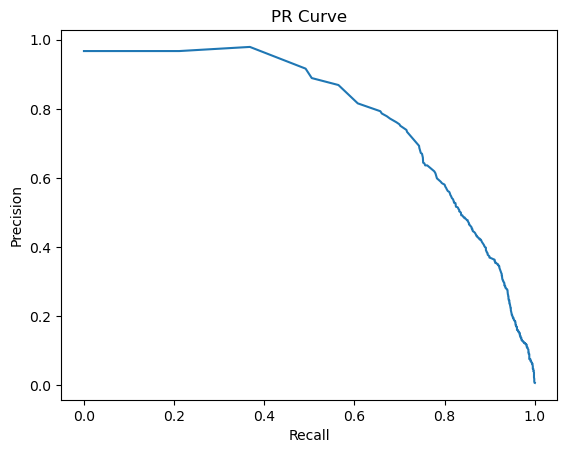

In [24]:
import matplotlib.pyplot as plt

# Returns as a list (false positive rate, true positive rate)
preds_list = preds.select('is_fraud','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['is_fraud'])))
points = CurveMetrics(preds_list).get_curve('pr')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(x_val, y_val)
plt.show()

### Probability Threshold Fine Tuning

By default the probability threshold of the model is 0.5 (50%). Anything above is assessed as a positive. In this section we test different probability thresholds, and use the f1-score as the metric to select the best threshold.

In [25]:
# formula for thresholds where p is the probability of class 1:
# [a,b] where a = 1, b = p / (1 - p)

bestScore = 0
bestThreshold = 0

for p in [0.5, 0.6, 0.7, 0.8, 0.9]:
    
    # use this if using cross-validated pipeline
    # model.stages[-1].bestModel.setThresholds([1,p/(1-p)])
    
    # use this if using single model (pre-tuned) pipeline
    model_two.stages[-1].setThresholds([1,p/(1-p)])
    
    preds_adj = model_two.transform(test)
    
    preds_float = preds_adj \
        .select("prediction", "is_fraud") \
        .withColumn("is_fraud", col("is_fraud").cast(DoubleType())) \
        .orderBy("prediction")

    cm = MulticlassMetrics(preds_float.rdd.map(tuple))
    
    precision = cm.precision(1.0)
    recall = cm.recall(1.0)
    f1Score = cm.fMeasure(1.0)
    print("Summary Stats for p = %s" % p)
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s\n" % f1Score)
    
    if (f1Score > bestScore):
        bestScore = f1Score
        bestThreshold = p
        
print("Best threshold = %s" % bestThreshold)

Summary Stats for p = 0.5
Precision = 0.27305366591080876
Recall = 0.9395318595578673
F1 Score = 0.4231332357247438



Summary Stats for p = 0.6
Precision = 0.3156845369960124
Recall = 0.9265279583875162
F1 Score = 0.47091870456047585



Summary Stats for p = 0.7
Precision = 0.383008356545961
Recall = 0.8940182054616385
F1 Score = 0.5362714508580344



Summary Stats for p = 0.8
Precision = 0.46335447498238197
Recall = 0.8550065019505851
F1 Score = 0.6010054844606947



Summary Stats for p = 0.9
Precision = 0.5844901866921972
Recall = 0.793888166449935
F1 Score = 0.6732837055417701

Best threshold = 0.9


In [26]:
# use this if using cross-validated pipeline
# model_two.stages[-1].bestModel.setThresholds([1,bestThreshold/(1-bestThreshold)])

# use this if using single model (pre-tuned) pipeline
model_two.stages[-1].setThresholds([1,bestThreshold/(1-bestThreshold)])

GBTClassificationModel: uid = GBTClassifier_c72526f95ce0, numTrees=20, numClasses=2, numFeatures=584

### Feature Importances Extraction and Analysis

Extraction of features using the technique shown [here](https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator). The plot confirms our EDA findings that key differentiators for fraud detection are transactions amounts, specific categories of shopping (online) and late hours of the day.

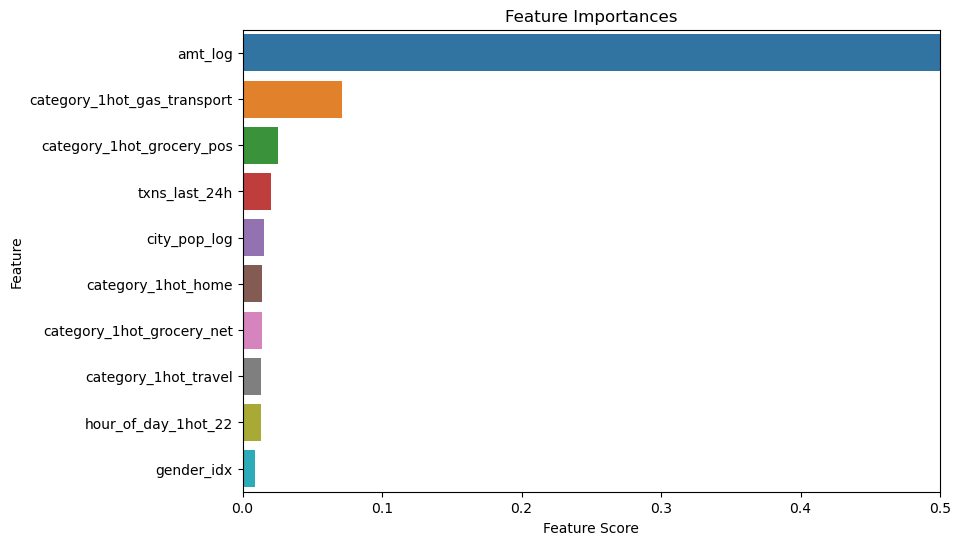

In [27]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

# retrieve top 10 features
features = ExtractFeatureImp(model_two.stages[-1].featureImportances, preds, "features").head(10)

# visualize feature importances
plt.figure(figsize=(9, 6))
sns.barplot(x='score', y='name', data=features, orient='h')
plt.title('Feature Importances')
plt.xlabel('Feature Score')
plt.ylabel('Feature')
plt.xlim(0, 0.5)
plt.show()

## Real Time Prediction Prototype 1 - Streaming From CSV

In [0]:
# Set the following value to True if you want to test drive streaming
enableStreaming = False
# Set to true if running locally, false if run on Databricks
isLocal = False

inputPath = 'events' if isLocal else "/Filestore/events"

In [0]:
if (enableStreaming):

    # Select a few fraudulent transactions from the test data set and write them to file.
    testData = test.where(col("is_fraud")==1.0).sample(0.01).repartition(100)
    testData.write.mode("overwrite").format("CSV").option("header",True).save(inputPath)

In [0]:
# establish event stream
if (enableStreaming):
    file_events = spark.readStream.format("csv") \
                             .option("header",True) \
                             .schema(ccschema) \
                             .option("ignoreLeadingWhiteSpace",True) \
                             .option("mode","dropMalformed") \
                             .option("maxFilesPerTrigger",1) \
                             .load(inputPath) \
                             .withColumn("window", window("trans_date_trans_time", "24 hours", "24 hours"))

In [0]:
# create a running aggregate query - transactions over the last 24 hrs
if (enableStreaming):
    file_last24Counts = file_events \
        .withWatermark("trans_date_trans_time", "24 hours") \
        .groupBy(window("trans_date_trans_time", "24 hours", "24 hours"), file_events.cc_num) \
        .agg(count("*").alias("txns_last_24h"))

In [0]:
# sink the aggregates in an in-memory table. That was the only
# stable way we found to allow the event stream to join with
# the aggregates table
if (enableStreaming):
    file_last24Counts \
        .writeStream \
        .queryName("file_txns_last_24h") \
        .outputMode("complete") \
        .format("memory") \
        .start()

In [0]:
# join the events and aggregates streamed dataframes
if (enableStreaming):
    file_events_joined = file_events.join(spark.table("file_txns_last_24h"), ["window", "cc_num"], "leftouter")

In [0]:
if (enableStreaming):
    # make predictions as new batches come in.
    # to stop this process, interrupt the kernel with the stop button
    file_predStream = model_two.transform(file_events_joined).select("trans_date_trans_time", 
                                                "cc_num", "amt", "prediction")

    # write to console as new batches come in
    file_predStream.writeStream.format("console").outputMode("append").start().awaitTermination()

## Real Time Prediction Prototype 2 - Streaming from Kafka

In [28]:
# set this to True to enable Kafka streaming

enableKafka = True

In [29]:
# define Kafka event sink

if (enableKafka):
    df = spark.readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", "localhost:9092") \
        .option("subscribe", "cc_fraud_topic") \
        .load()

    # print the schema
    df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [30]:
# cast Kafka's event data from binary to string

if (enableKafka):
    stringDF = df.selectExpr("CAST(value AS STRING)")

In [31]:
from pyspark.sql.functions import from_csv

# define event stream by extracting the event data from Kafka and
# parsing it with the schema. The transaction's rolling 24 window 
# is also added as a feature for future use

if (enableKafka):
    events = stringDF.select(from_csv(col("value"),ccschema.simpleString()).alias("data")) \
                     .select("data.*") \
                     .withColumn("window", window("trans_date_trans_time", "24 hours", "24 hours"))

In [32]:
# create the aggregate query
if (enableKafka):
    last24Counts = events\
        .withWatermark("trans_date_trans_time", "24 hours") \
        .groupBy(window("trans_date_trans_time", "24 hours", "24 hours"), events.cc_num) \
        .agg(count("*").alias("txns_last_24h"))

In [33]:
# Have all the aggregates in an in-memory table. The query name will be the table name
if (enableKafka):
    last24Counts \
        .writeStream \
        .queryName("txns_last_24h") \
        .outputMode("complete") \
        .format("memory") \
        .start()

In [34]:
# join the aggregate dataframe with the original dataframe

if (enableKafka):
    events_joined = events.join(spark.table("txns_last_24h"), ["window", "cc_num"], "leftouter")

In [35]:
if (enableKafka):
    # make predictions as new batches come in.
    # to stop this process, interrupt the kernel with the stop button
    predStream = model.transform(events_joined).select("trans_date_trans_time", 
                                                "cc_num", "amt", "prediction")

    # write to console as new batches come in
    predStream.writeStream.format("console").outputMode("append").start().awaitTermination()

-------------------------------------------
Batch: 0
-------------------------------------------
+---------------------+------+---+----------+
|trans_date_trans_time|cc_num|amt|prediction|
+---------------------+------+---+----------+
+---------------------+------+---+----------+



-------------------------------------------
Batch: 1
-------------------------------------------
+---------------------+----------------+-----+----------+
|trans_date_trans_time|          cc_num|  amt|prediction|
+---------------------+----------------+-----+----------+
|  2023-12-01 10:00:00|4430881574719618|10.12|       0.0|
+---------------------+----------------+-----+----------+



-------------------------------------------
Batch: 2
-------------------------------------------
+---------------------+-------------------+-------+----------+
|trans_date_trans_time|             cc_num|    amt|prediction|
+---------------------+-------------------+-------+----------+
|  2023-12-09 23:23:10|4810839835482794272|8040.83|       1.0|
+---------------------+-------------------+-------+----------+



23/12/09 22:22:56 ERROR MicroBatchExecution: Query txns_last_24h [id = 98dc1bb0-7dab-4991-ada2-6aaaf9ac33fd, runId = 454ba536-f2b8-434d-89a6-8e3fd783271b] terminated with error
java.util.concurrent.ExecutionException: org.apache.kafka.common.errors.TimeoutException: Timed out waiting for a node assignment. Call: describeTopics
	at java.base/java.util.concurrent.CompletableFuture.reportGet(CompletableFuture.java:396)
	at java.base/java.util.concurrent.CompletableFuture.get(CompletableFuture.java:2073)
	at org.apache.kafka.common.internals.KafkaFutureImpl.get(KafkaFutureImpl.java:165)
	at org.apache.spark.sql.kafka010.ConsumerStrategy.retrieveAllPartitions(ConsumerStrategy.scala:66)
	at org.apache.spark.sql.kafka010.ConsumerStrategy.retrieveAllPartitions$(ConsumerStrategy.scala:65)
	at org.apache.spark.sql.kafka010.SubscribeStrategy.retrieveAllPartitions(ConsumerStrategy.scala:102)
	at org.apache.spark.sql.kafka010.SubscribeStrategy.assignedTopicPartitions(ConsumerStrategy.scala:113)
	at

StreamingQueryException: [STREAM_FAILED] Query [id = d7b9566f-d34b-4905-a4bd-856b44cf19dc, runId = 55c42790-8189-4021-9940-30d3aa012931] terminated with exception: org.apache.kafka.common.errors.TimeoutException: Timed out waiting for a node assignment. Call: describeTopics